In [78]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from tools import load_regression_iris
from scipy.stats import multivariate_normal


Section 1:

In [79]:
X, t = load_regression_iris()
N, D = X.shape
print(N,D)

150 3


In [108]:
def mvn_basis(
    features: torch.Tensor,
    mu: torch.Tensor,
    var: float
) -> torch.Tensor:
    '''
    Multivariate Normal Basis Function
    The function transforms (possibly many) data vectors <features>
    to an output basis function output <fi>
    Inputs:
    * features: [NxD] is a data matrix with N D-dimensional
    data vectors.
    * mu: [MxD] matrix of M D-dimensional mean vectors defining
    the multivariate normal distributions.
    * var: All normal distributions are isotropic with sigma*I covariance
    matrices (where I is the MxM identity matrix)
    Output:
    * fi - [NxM] is the basis function vectors containing a basis function
    output fi for each data vector x in features
    '''
    #features_np = features.numpy()
    #mu_np = mu.numpy()
    ## Not allowed to use numpy...
    N, D = features.shape
    M = mu.shape[0]
    covariance_matrix = var * torch.eye(D)

    # Create a list to store the results
    phi = torch.zeros((N, M))

    # Loop over each mean vector 
    for i in range(M):
    # Create a multivariate normal distribution for each mean vector
        dist = multivariate_normal(mean=mu[i], cov=covariance_matrix)
        phi[:, i] = torch.from_numpy(dist.pdf(features))
    return phi




In [81]:

def mvn_basis1(features: torch.Tensor, mu: torch.Tensor, sigma: float) -> torch.Tensor:
    '''
    Multivariate Normal Basis Function
    Transforms data vectors (features) to basis function output <fi>.
    
    Inputs:
    * features: [NxD] Tensor with N D-dimensional data vectors.
    * mu: [MxD] Tensor of M D-dimensional mean vectors.
    * sigma: Scalar value for isotropic covariance.
    
    Output:
    * fi: [NxM] Tensor of basis function values for each data vector in features.
    '''
    N, D = features.shape
    M = mu.shape[0]
    
    # Compute squared distances between each feature and each mean
    diff = features[:, None, :] - mu[None, :, :]  # Shape: [N, M, D]
    squared_distances = torch.sum(diff ** 2, dim=-1)  # Shape: [N, M]
    
    # Compute the multivariate normal basis function values (Gaussian RBF)
    norm_const = (2 * torch.pi * sigma) ** (-D / 2)
    phi = norm_const * torch.exp(-squared_distances / (2 * sigma))  # Shape: [N, M]
    
    return phi

In [109]:
fi1=mvn_basis(X,mu,var)
print(fi1)

tensor([[0.0017, 0.0018, 0.0018,  ..., 0.0007, 0.0005, 0.0003],
        [0.0019, 0.0019, 0.0019,  ..., 0.0006, 0.0004, 0.0003],
        [0.0018, 0.0019, 0.0019,  ..., 0.0006, 0.0004, 0.0002],
        ...,
        [0.0006, 0.0009, 0.0012,  ..., 0.0019, 0.0017, 0.0014],
        [0.0006, 0.0008, 0.0011,  ..., 0.0019, 0.0017, 0.0015],
        [0.0007, 0.0010, 0.0013,  ..., 0.0018, 0.0016, 0.0013]])


In [83]:
M, var = 10, 10
mu = torch.zeros((M, D))
for i in range(D):
    mmin = torch.min(X[:, i])
    mmax = torch.max(X[:, i])
    mu[:, i] = torch.linspace(mmin, mmax, M)
fi = mvn_basis(X, mu, var)

In [84]:
print(fi)

tensor([[0.0017, 0.0018, 0.0018,  ..., 0.0007, 0.0005, 0.0003],
        [0.0019, 0.0019, 0.0019,  ..., 0.0006, 0.0004, 0.0003],
        [0.0018, 0.0019, 0.0019,  ..., 0.0006, 0.0004, 0.0002],
        ...,
        [0.0006, 0.0009, 0.0012,  ..., 0.0019, 0.0017, 0.0014],
        [0.0006, 0.0008, 0.0011,  ..., 0.0019, 0.0017, 0.0015],
        [0.0007, 0.0010, 0.0013,  ..., 0.0018, 0.0016, 0.0013]],
       dtype=torch.float64)


Section 2

In [85]:
print(fi.shape)

torch.Size([150, 10])


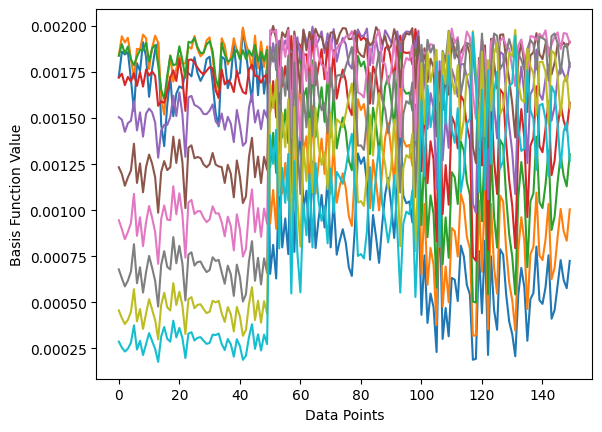

In [110]:
def _plot_mvn():
    fi = mvn_basis(X, mu, var)
    #print(fi[:,0])
    M = mu.shape[0]
    for i in range(M):
        plt.plot(fi[:,i])
    plt.xlabel("Data Points")
    plt.ylabel("Basis Function Value")
    plt.savefig('2_1.png')
    plt.show()

_plot_mvn()

Section 3

In [88]:
def max_likelihood_linreg(
    fi: torch.Tensor,
    targets: torch.Tensor,
    lamda: float
) -> torch.Tensor:
    '''
    Estimate the maximum likelihood values for the linear model

    Inputs :
    * Fi: [NxM] is the array of basis function vectors
    * t: [Nx1] is the target value for each input in Fi
    * lamda: The regularization constant

    Output: [Mx1], the maximum likelihood estimate of w for the linear model
    '''
    N, M = fi.shape
    
    # Compute (Phi^T Phi + lamda * I)
    regularization_term = lamda * torch.eye(M)
    FiT_Fi = torch.matmul(fi.T, fi)
    
    # Compute the MLE estimate for w
    wml = torch.linalg.solve(FiT_Fi + regularization_term, torch.matmul(fi.T, targets))
    
    return wml

In [89]:
lamda = 0.001
wml = max_likelihood_linreg(fi,t,lamda)

In [90]:
print(wml)

tensor([  4.2790,  17.5758,  34.9175,  54.4687,  73.4915,  88.9634,  98.3602,
        100.3262,  94.9886,  83.8179], dtype=torch.float64)


In [105]:
wml.dtype

torch.float64

Section 4

In [91]:
def linear_model(
    features: torch.Tensor,
    mu: torch.Tensor,
    var: float,
    w: torch.Tensor
) -> torch.Tensor:
    '''
    Inputs:
    * features: [NxD] is a data matrix with N D-dimensional data vectors.
    * mu: [MxD] matrix of M D dimensional mean vectors defining the
    multivariate normal distributions.
    * var: All normal distributions are isotropic with sigma^2*I covariance
    matrices (where I is the MxM identity matrix).
    * w: [Mx1] the weights, e.g. the output from the max_likelihood_linreg
    function.

    Output: [Nx1] The prediction for each data vector in features
    '''
    fi = mvn_basis(features, mu, var)
    
    # Step 2: Compute the predicted targets using the linear model
    predictions = torch.matmul(fi, w)
    
    return predictions

In [61]:
prediction = linear_model(X, mu, var, wml)

In [71]:
print(prediction.shape)

torch.Size([150])


In [97]:
print(t)

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.4000, 0.3000, 0.2000, 0.2000,
        0.1000, 0.2000, 0.2000, 0.1000, 0.1000, 0.2000, 0.4000, 0.4000, 0.3000,
        0.3000, 0.3000, 0.2000, 0.4000, 0.2000, 0.5000, 0.2000, 0.2000, 0.4000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.4000, 0.1000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.1000, 0.2000, 0.2000, 0.3000, 0.3000, 0.2000, 0.6000, 0.4000,
        0.3000, 0.2000, 0.2000, 0.2000, 0.2000, 1.4000, 1.5000, 1.5000, 1.3000,
        1.5000, 1.3000, 1.6000, 1.0000, 1.3000, 1.4000, 1.0000, 1.5000, 1.0000,
        1.4000, 1.3000, 1.4000, 1.5000, 1.0000, 1.5000, 1.1000, 1.8000, 1.3000,
        1.5000, 1.2000, 1.3000, 1.4000, 1.4000, 1.7000, 1.5000, 1.0000, 1.1000,
        1.0000, 1.2000, 1.6000, 1.5000, 1.6000, 1.5000, 1.3000, 1.3000, 1.3000,
        1.2000, 1.4000, 1.2000, 1.0000, 1.3000, 1.2000, 1.3000, 1.3000, 1.1000,
        1.3000, 2.5000, 1.9000, 2.1000, 1.8000, 2.2000, 2.1000, 1.7000, 1.8000,
        1.8000, 2.5000, 2.0000, 1.9000, 

Section 5

In [67]:
def _square_error(t, prediction):
    y_hat = prediction.numpy()
    y = t.numpy()
    error = (y-y_hat)**2
    return error

In [72]:
sq_error = _square_error(t, prediction)
print(sq_error.shape)

(150,)


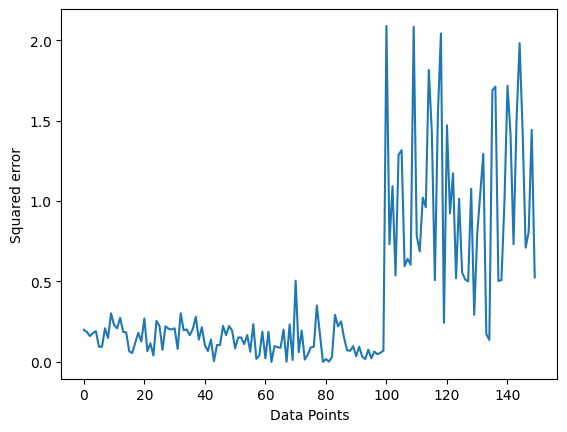

In [92]:
plt.plot(sq_error, label='Squared Error')
plt.xlabel("Data Points")
plt.ylabel("Squared error")
plt.savefig('5_a.png')
plt.show()

In [95]:
def plot_predictions_vs_actual(predictions: torch.Tensor, targets: torch.Tensor):
    '''
    Plot predictions vs actual target values.
    
    Inputs:
    * predictions: [Nx1] Tensor of predicted values.
    * targets: [Nx1] Tensor of actual target values.
    '''
    # Convert PyTorch tensors to NumPy arrays for plotting
    predictions_np = predictions.numpy()
    targets_np = targets.numpy()
    
    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(targets_np, predictions_np, color='blue', label='Predictions')
    
    # Plot a line of perfect predictions (where predictions == targets)
    min_val = min(targets_np.min(), predictions_np.min())
    max_val = max(targets_np.max(), predictions_np.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Correct Prediction')
    
    # Set plot labels and title
    plt.xlabel('Actual Target Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions vs. Actual Target Values')
    plt.savefig('5_b.png')
    plt.legend()
    
    # Show the plot
    plt.show()



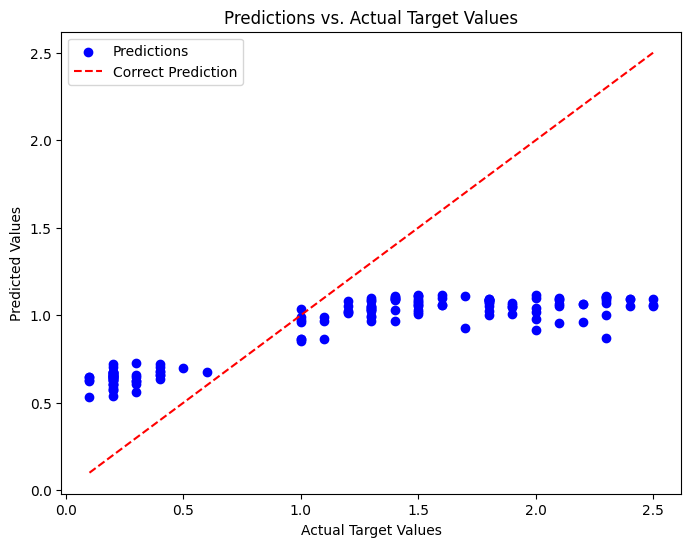

In [96]:
# Plot predictions vs actual target values
plot_predictions_vs_actual(prediction, t)